In [2]:
from sarif import loader

path_to_sarif_file = "data.sarif"

sarif_data = loader.load_sarif_file(path_to_sarif_file)
issue_count_by_severity = sarif_data.get_result_count_by_severity()
error_histogram = sarif_data.get_issue_code_histogram("error")

In [3]:
help(sarif_data)

Help on SarifFile in module sarif.sarif_file object:

class SarifFile(builtins.object)
 |  SarifFile(file_path, data)
 |  
 |  Class to hold SARIF data parsed from a file and provide accesssors to the data.
 |  
 |  Methods defined here:
 |  
 |  __bool__(self)
 |      True if non-empty.
 |  
 |  __init__(self, file_path, data)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_abs_file_path(self) -> str
 |      Get the absolute file path from which this SARIF data was loaded.
 |  
 |  get_distinct_tool_names(self)
 |      Return a list of tool names that feature in the runs in this file.
 |      The list is deduplicated and sorted into alphabetical order.
 |  
 |  get_file_name(self) -> str
 |      Get the file name from which this SARIF data was loaded.
 |  
 |  get_file_name_extension(self) -> str
 |      Get the extension of the file name from which this SARIF data was loaded.
 |      Initial "." exlcuded.
 |  
 |  get_file_name_without_extension(se

In [4]:
records = sarif_data.get_records()
import pandas as pd
df = pd.DataFrame.from_records(records)
df.head()

Tool                                    Location Line Severity  \
0  CodeQL  error_correction_repetition_code_e94ab1.py  222  warning   
1  CodeQL  error_correction_repetition_code_e94ab1.py  249  warning   
2  CodeQL  error_correction_repetition_code_e94ab1.py  275  warning   
3  CodeQL  error_correction_repetition_code_e94ab1.py  303  warning   
4  CodeQL                             h2evo_6bb46f.py   42  warning   

                                                Code  
0  ql-ghost-composition Ghost composition at loca...  
1  ql-ghost-composition Ghost composition at loca...  
2  ql-ghost-composition Ghost composition at loca...  
3  ql-ghost-composition Ghost composition at loca...  
4  ql-ghost-composition Ghost composition at loca...

In [5]:
# add rule parsed from the first word of Code
df["rule"] = df["Code"].apply(
    lambda x: x.split()[0] if isinstance(x, str) else None
)
df.head()

Tool                                    Location Line Severity  \
0  CodeQL  error_correction_repetition_code_e94ab1.py  222  warning   
1  CodeQL  error_correction_repetition_code_e94ab1.py  249  warning   
2  CodeQL  error_correction_repetition_code_e94ab1.py  275  warning   
3  CodeQL  error_correction_repetition_code_e94ab1.py  303  warning   
4  CodeQL                             h2evo_6bb46f.py   42  warning   

                                                Code                  rule  
0  ql-ghost-composition Ghost composition at loca...  ql-ghost-composition  
1  ql-ghost-composition Ghost composition at loca...  ql-ghost-composition  
2  ql-ghost-composition Ghost composition at loca...  ql-ghost-composition  
3  ql-ghost-composition Ghost composition at loca...  ql-ghost-composition  
4  ql-ghost-composition Ghost composition at loca...  ql-ghost-composition

<Axes: xlabel='count', ylabel='rule'>

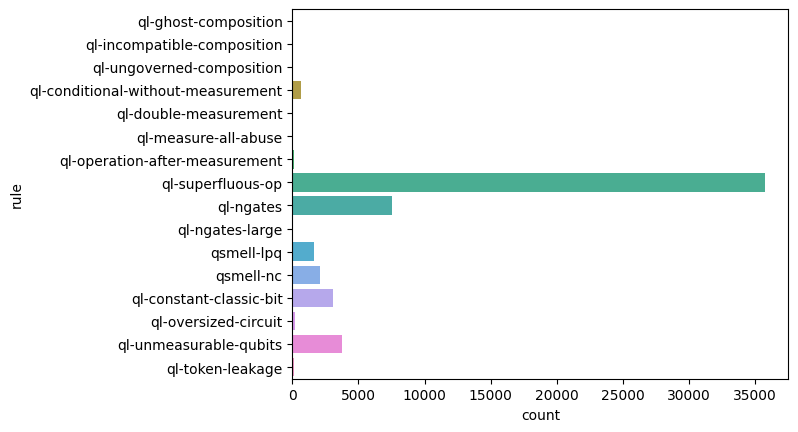

In [6]:
import seaborn as sns

sns.countplot(
    data=df, 
    y="rule"
)

<Axes: xlabel='count', ylabel='rule'>

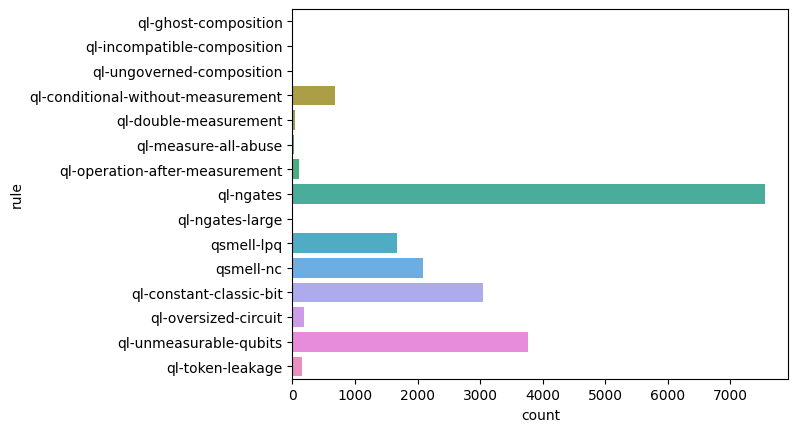

In [7]:
blacklisted_rules = [
    "ql-superfluous-op", "ql-constant-classical-bit"
]
df_filtered = df[~df["rule"].isin(blacklisted_rules)]
sns.countplot(
    data=df_filtered, 
    y="rule"
)

In [8]:
# read sarif as json
import json

with open(path_to_sarif_file) as f:
    my_data = json.load(f)


In [9]:
len(my_data)

3

In [10]:
from tqdm import tqdm

all_results = my_data["runs"][0]["results"]
all_length_record = []

for r in tqdm(all_results):
    all_length_record.append({
        "ruleId": r["ruleId"],
        "length": len(str(r)),
        "location": r["locations"][0]["physicalLocation"]["artifactLocation"]["uri"]
    })

df_record_length = pd.DataFrame.from_records(all_length_record)


100%|██████████| 55091/55091 [00:02<00:00, 19081.08it/s] 


In [11]:
all_results[0]["locations"][0]["physicalLocation"]["artifactLocation"]["uri"]

'error_correction_repetition_code_e94ab1.py'

<Axes: xlabel='count', ylabel='location'>

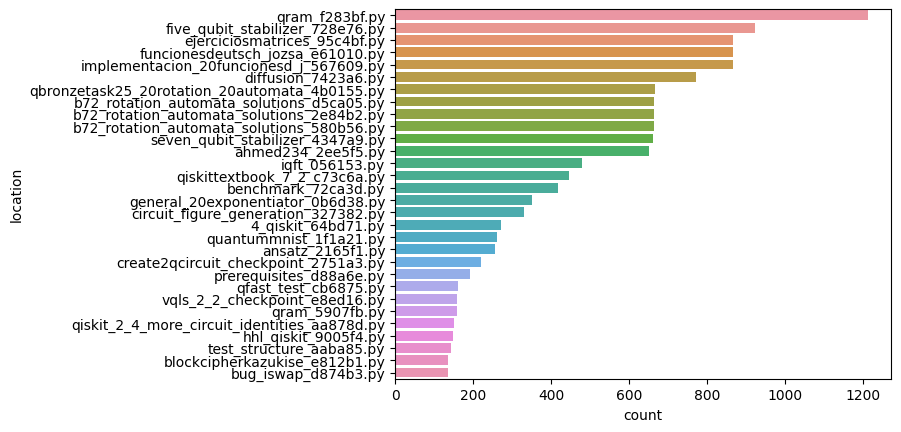

In [12]:
top_k = 30
# get top k popular locations
top_k_locations = df_record_length["location"].value_counts().index[:top_k]

sns.countplot(
    data=df_record_length[df_record_length["location"].isin(top_k_locations)],
    order=df_record_length["location"].value_counts().index[:top_k],
    y="location"
)

<Axes: xlabel='length', ylabel='Count'>

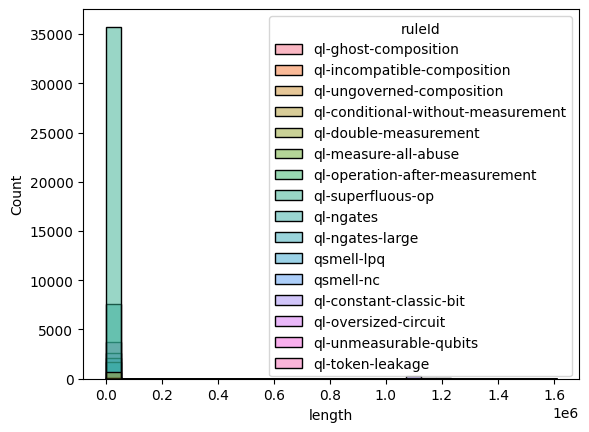

In [13]:
sns.histplot(
    data=df_record_length, 
    x="length",
    hue="ruleId",
    bins=30
)

In [19]:
# keep where length is above 1000
CUT_OFF_CHARS = 10000
df_super_long = df_record_length[df_record_length["length"] > CUT_OFF_CHARS]
print(f"Found {len(df_super_long)} records with length > {CUT_OFF_CHARS} chars.")
n_files = df_super_long["location"].nunique()
files_w_long_warnings = df_super_long["location"].unique()
print(f"Found {n_files} files with warnings with length > {CUT_OFF_CHARS} chars.")
df_super_long.head(100)

Found 437 records with length > 10000 chars.
Found 303 files with warnings with length > 10000 chars.


ruleId   length                           location
718      ql-double-measurement  1609234                   qubits_d78ad0.py
719      ql-double-measurement  1609157                   qubits_d78ad0.py
720      ql-double-measurement  1609240             qubits_intro_974f92.py
721      ql-double-measurement  1609163             qubits_intro_974f92.py
20275        ql-superfluous-op   204120                     main_2c7211.py
...                        ...      ...                                ...
49199  ql-constant-classic-bit  1169344             helper_funcs_238b3d.py
49200  ql-constant-classic-bit  1109338                  helpers_9fdc24.py
49201  ql-constant-classic-bit  1109339                  helpers_9fdc24.py
49202  ql-constant-classic-bit  1109338                  helpers_9fdc24.py
49203  ql-constant-classic-bit  1189355  herrtestcomptimetiffoli_cf1dac.py

[100 rows x 3 columns]

<Axes: xlabel='count', ylabel='ruleId'>

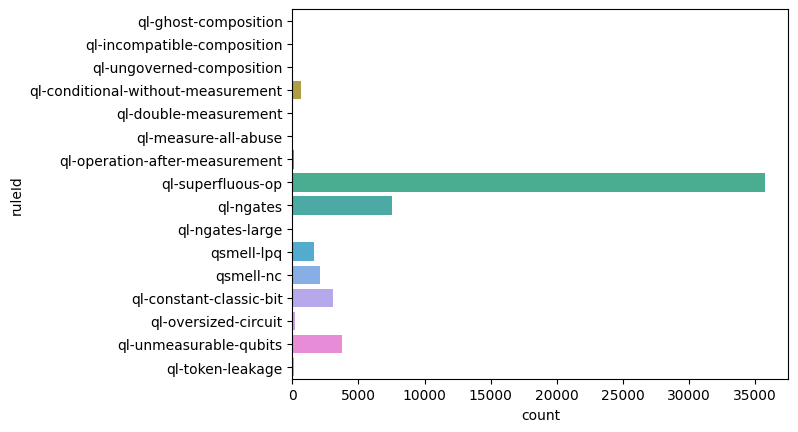

In [14]:
sns.countplot(
    data=df_record_length, 
    y="ruleId",
)

In [23]:
filtered_results = [
    r for r in all_results 
    if r["ruleId"] not in blacklisted_rules 
    and r["locations"][0]["physicalLocation"]["artifactLocation"]["uri"] not in files_w_long_warnings]
print(f"Original: {len(all_results)} vs Filtered: {len(filtered_results)}")

Original: 55091 vs Filtered: 17727


In [32]:
# inspect some result filtered out
super_long_result = [
    r for r in all_results
    if r["locations"][0]["physicalLocation"]["artifactLocation"]["uri"]  in files_w_long_warnings
    and len(str(r)) > CUT_OFF_CHARS
]
# shuffle 
import random
# set seed
random.seed(426)

FILTER_RULE = "ql-double-measurement"
# keep only those with filter rule
super_long_result = [
    r for r in super_long_result
    if r["ruleId"] == FILTER_RULE
]
random.shuffle(super_long_result)

TO_INSPECT = 5
for i in range(TO_INSPECT):
    i_warning = super_long_result[i]
    location = i_warning["locations"][0]["physicalLocation"]["artifactLocation"]["uri"]
    msg = i_warning["message"]["text"]
    print(f"--- {location}")
    print(msg)

--- qubits_d78ad0.py
Two consecutive measurements on qubit '1' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '2' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '3' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '4' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '5' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '6' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '7' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '8' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '9' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '10' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '11' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '12' at locations: (15, 1) and (23, 1)
Two consecutive measurements on qubit '13' at locations: (15, 1)

IndexError: list index out of range

In [31]:
# counte the values of each rule
from collections import Counter

all_rules_from_long_results = [
    r["ruleId"] for r in super_long_result
]
c = Counter(all_rules_from_long_results)

top_k = 30
c.most_common(top_k)

[('ql-constant-classic-bit', 432),
 ('ql-double-measurement', 4),
 ('ql-superfluous-op', 1)]

In [24]:

# create a new file
new_data = my_data
new_data["runs"][0]["results"] = filtered_results
n_filterd_results = len(filtered_results)
print(f"Filtered {n_filterd_results} results.") 
# save json as new_data.sarif
with open("new_data.sarif", "w") as f:
    json.dump(new_data, f)

Filtered 17727 results.


In [24]:
filtered_results[0]

{'ruleId': 'ql-ghost-composition',
 'ruleIndex': 0,
 'rule': {'id': 'ql-ghost-composition', 'index': 0},
 'message': {'text': 'Ghost composition at location: (222, 1)'},
 'locations': [{'physicalLocation': {'artifactLocation': {'uri': 'error_correction_repetition_code_e94ab1.py',
     'uriBaseId': '%SRCROOT%',
     'index': 0},
    'region': {'startLine': 222, 'endColumn': 20}}}],
 'partialFingerprints': {'primaryLocationLineHash': '7c0c3ac8058fc1e6:1',
  'primaryLocationStartColumnFingerprint': '0'}}

In [21]:
my_data["runs"][0].keys()

dict_keys(['tool', 'artifacts', 'results', 'columnKind', 'properties'])

In [23]:
prop = my_data["runs"][0]["properties"]
prop.keys()

dict_keys(['semmle.formatSpecifier'])